<a href="https://colab.research.google.com/github/AhmdKlmi22/Training_Model/blob/main/TUGAS2_HYPERPARAMETER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install tensorflow opencv-python matplotlib split-folders

In [19]:
pip install split-folders

In [20]:
import splitfolders  # Library khusus untuk split dataset
import zipfile

# 🛠️ SESUAIKAN PATH DAN UKURAN GAMBAR
dataset_path = "/content/drive/MyDrive/Data_Tugas/dompet.zip"  # Ganti dengan path mu
img_size = (150, 150)  # Bisa ubah ke (224,224) untuk model lebih kompleks

# Ekstrak dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/drive/MyDrive/Data_Tugas/dataset_raw")

# Split dataset jadi train/val/test (80/10/10)
splitfolders.ratio(
    "/drive/MyDrive/Data_Tugas/dataset_raw",
    output="/drive/MyDrive/Data_Tugas/dataset_split",
    seed=42,
    ratio=(0.8, 0.1, 0.1)
)

print("Dataset sudah di-split!")

Copying files: 1245 files [00:00, 2873.74 files/s]

Dataset sudah di-split!


In [21]:
# ------------------------- CELL 1: DATA GENERATOR -------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🛠️ PARAMETER AUGMENTASI (ResNet50-friendly)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,        # Lebih kecil untuk ResNet
    width_shift_range=0.1,    # Reduced untuk fine-tuning
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,           # Augmentasi subtle
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1      # 90% train, 10% val
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# 🛠️ BATCH SIZE (optimal untuk ResNet50)
batch_size = 50

# 🚀 Generator untuk ResNet50 (224x224)
train_generator = train_datagen.flow_from_directory(
    "drive/MyDrive/Data_Tugas/",  # PASTIKAN PATH BENAR!
    target_size=(224, 224),  # ResNet50 wajib 224x224
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    "drive/MyDrive/Data_Tugas/",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    "drive/MyDrive/Data_Tugas/",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 180 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [22]:
# ------------------------- CELL 2: RESNET50 MODEL -------------------------
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# 1. Load Base Model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. Freeze Layers (80% pertama)
for layer in base_model.layers[:140]:
    layer.trainable = False

# 3. Custom Head untuk 4 kelas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)  # Tambahan baru
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4. Compile dengan optimasi
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)  # 💡 Tambah metric precision & recall

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,694,084 (98.02 MB)

 Trainable params: 17,082,372 (65.16 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [23]:
# ------------------------- CELL 2: RESNET50 MODEL -------------------------
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf  # Pastikan ini juga sudah diimpor

# Load base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze 140 layer pertama
for layer in base_model.layers[:140]:
    layer.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Bentuk dan compile model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [24]:
# ------------------------- CELL 3: TRAINING -------------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# 🛠️ Callbacks Canggih
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Lebih sabar
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('training_log.csv')  # 🚀 Auto save log
]

# 🚀 Training dengan auto-steps
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Pakai semua batch
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.2208 - loss: 15.5425 - precision_5: 0.2406 - recall_5: 0.1616 - val_accuracy: 1.0000 - val_loss: 14.4674 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 828ms/step - accuracy: 0.2154 - loss: 15.5671 - precision_5: 0.2629 - recall_5: 0.1560 - val_accuracy: 1.0000 - val_loss: 14.3975 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 765ms/step - accuracy: 0.2191 - loss: 15.3516 - precision_5: 0.2212 - recall_5: 0.1297 - val_accuracy: 1.0000 - val_loss: 14.3184 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - accuracy: 0.2833 - loss: 15.1946 - precision_5: 0.3310 - recall_5: 0.1951 - val_accuracy: 1.0000 - val_loss: 14.2296 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - learning_rat

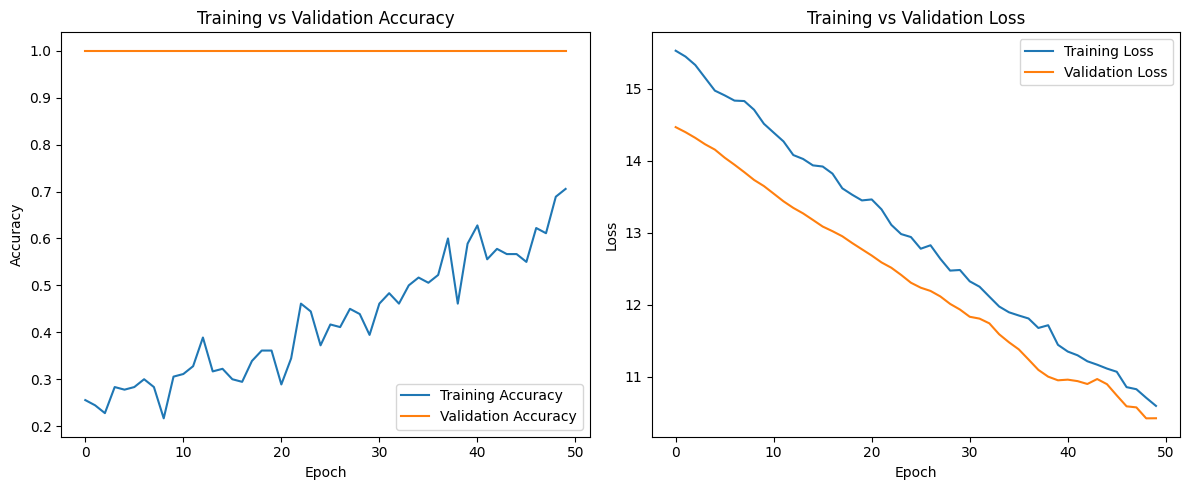

In [26]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


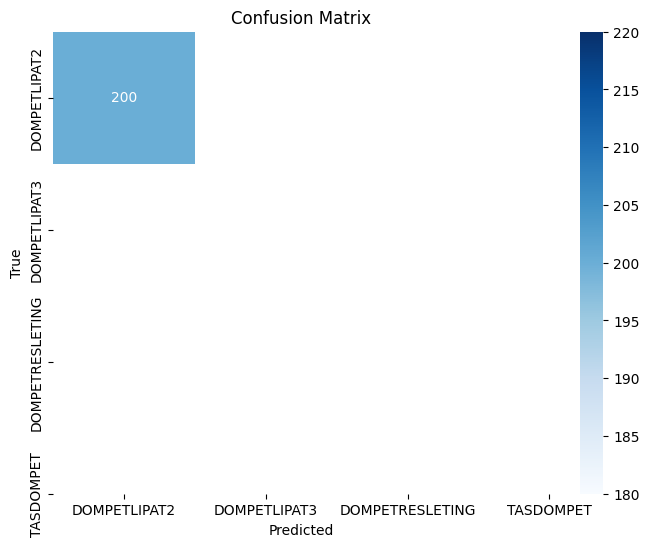

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prediksi data test
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
true_classes = test_generator.classes

# Buat Confusion Matrix
cm = confusion_matrix(true_classes, test_pred_classes)
class_names = list(test_generator.class_indices.keys())

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
from sklearn.metrics import classification_report

print(classification_report(
    true_classes,
    test_pred_classes,
    target_names=class_names
))

ValueError: Number of classes, 1, does not match size of target_names, 4. Try specifying the labels parameter